In [1]:
import os
del os.environ['CONDA_PREFIX']
import git
import time
import numpy as np
import pandas as pd
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
from collections.abc import Iterable
sns.set_theme()

In [2]:
git_dir = "/home/yakov/code/nyccovid/coronavirus-data"

In [3]:
repo = git.Repo(path=git_dir)

In [4]:
heads = repo.heads
master = heads.master
commits = list(repo.iter_commits(master))
print(len(commits))

269


In [5]:
commit = master.commit

In [6]:
commit

<git.Commit "fef6e6109ad6e9d22626c79f1037cff7b9af2993">

In [7]:
commit.tree

<git.Tree "017b534d00bc429a56034753b031c3bf5b91971c">

In [8]:
time.strftime("%a, %d %b %Y %H:%M", time.gmtime(commit.committed_date))

'Tue, 13 Oct 2020 16:12'

In [9]:
pd.read_csv(StringIO(repo.git.show('{}:{}'.format(commit.hexsha, "summary.csv"))))

,MEASURE,NUMBER_OF_NYC_RESIDENTS
0,NYC_CASE_COUNT,245896
1,NYC_HOSPITALIZED_COUNT,57859
2,NYC_CONFIRMED_DEATH_COUNT,19251
3,NYC_PROBABLE_DEATH_COUNT,4644
4,DATE_UPDATED,"October 13, at 12:15 p.m."


In [10]:
hashes = [cmt.hexsha for cmt in repo.iter_commits(master, max_count=60)]
times = [pd.read_csv(StringIO(repo.git.show('{}:{}'.format(hash, "summary.csv")))).iloc[-1].iloc[-1] for hash in hashes]

In [11]:
keep_idxs = [idx for idx, timekey in enumerate(times) if timekey not in times[idx:][1:]]
keep_times = [timekey for idx, timekey in enumerate(times) if idx in keep_idxs]
keep_dates = [timekey.split(',')[0] for timekey in keep_times]

In [12]:
print(keep_dates)

['October 13', 'October 12', 'October 11', 'October 10', 'October  9', 'October  8', 'October  7', 'October  6', 'October  5', 'October  4', 'October  3', 'October  2', 'October  1', 'September 30', 'September 29', 'September 28', 'September 27', 'September 26', 'September 25', 'September 24', 'September 23', 'September 22', 'September 21', 'September 20', 'September 19', 'September 18', 'September 17', 'September 16', 'September 15', 'September 14', 'September 12', 'September 11', 'September 10', 'September  9', 'September  8', 'September  7', 'September  5', 'September  4', 'September  3', 'September  2', 'September  1', 'August 31', 'August 30', 'August 29', 'August 28', 'August 27', 'August 26', 'August 25', 'August 24', 'August 23', 'August 22', 'August 21', 'August 20', 'August 19', 'August 18']


In [13]:
data_dfs = [pd.read_csv(StringIO(repo.git.show('{}:{}'.format(hash, "data-by-modzcta.csv")))).set_index('MODIFIED_ZCTA') for hash_ix, hash in enumerate(hashes) if hash_ix in keep_idxs]
cdf = pd.concat(data_dfs[::-1], axis=1, keys=keep_times[::-1], names=['date', 'col']).swaplevel(axis=1)
ex_row = cdf.iloc[0].unstack(0).iloc[0]
numeric_cols = ex_row.index[ex_row.map(type) != str]
ndf = cdf[numeric_cols].diff(axis=1)
rdf = cdf[numeric_cols].diff(7, axis=1)
ndf.shape

(178, 385)

In [14]:
frac_pos = (rdf['COVID_CASE_COUNT'] / rdf['TOTAL_COVID_TESTS'])
lat_pos = frac_pos[keep_times[0]]
sort_zips = lat_pos.dropna().sort_values().index
zips = sort_zips.to_series()
nhds = cdf['NEIGHBORHOOD_NAME'][keep_times[0]][sort_zips]
recent_pos = lat_pos[sort_zips]
worst_pos_date = frac_pos.loc[sort_zips].idxmax(axis=1)
worst_pos = frac_pos.loc[sort_zips].max(axis=1)
compare_df = pd.concat([nhds, recent_pos, worst_pos_date, worst_pos], axis=1)
compare_df.columns = ['Neighborhood', '7-day mean', 'Worst date', 'Worst pos rate (daily)']
compare_df.tail(20)

,Neighborhood,7-day mean,Worst date,Worst pos rate (daily)
MODIFIED_ZCTA,,,,
11218,Kensington/Windsor Terrace,0.054054,"October 8, at 1 p.m.",0.066879
11229,Gerritsen Beach/Homecrest/Sheepshead Bay,0.054348,"October 6, at 1 p.m.",0.074597
11239,East New York,0.054545,"October 13, at 12:15 p.m.",0.054545
11235,Brighton Beach/Manhattan Beach/Sheepshead Bay,0.056351,"October 2, at 1 p.m.",0.087203
10305,Arrochar/Midland Beach/Shore Acres/South Beach...,0.059774,"October 13, at 12:15 p.m.",0.059774
11413,Laurelton/Rosedale,0.061381,"October 10, at 1 p.m.",0.072500
11435,Briarwood/Jamaica,0.062112,"October 9, at 1 p.m.",0.067437
11411,Cambria Heights,0.065359,"October 13, at 12:15 p.m.",0.065359
11416,Ozone Park,0.068702,"October 13, at 12:15 p.m.",0.068702


In [15]:
nhds[nhds.str.contains('Kew')]

MODIFIED_ZCTA
11415                  Kew Gardens
11367    Kew Gardens Hills/Pomonok
Name: October 13, at 12:15 p.m., dtype: object

In [16]:
zip_codes = [11435, 11367, 11691, 11217, 11219, 11415]
numzip = len(zip_codes)
height = int(np.floor(np.sqrt(numzip)))
width = numzip // height
if (height * width) < numzip:
    height += 1
print(height, width)

2 3


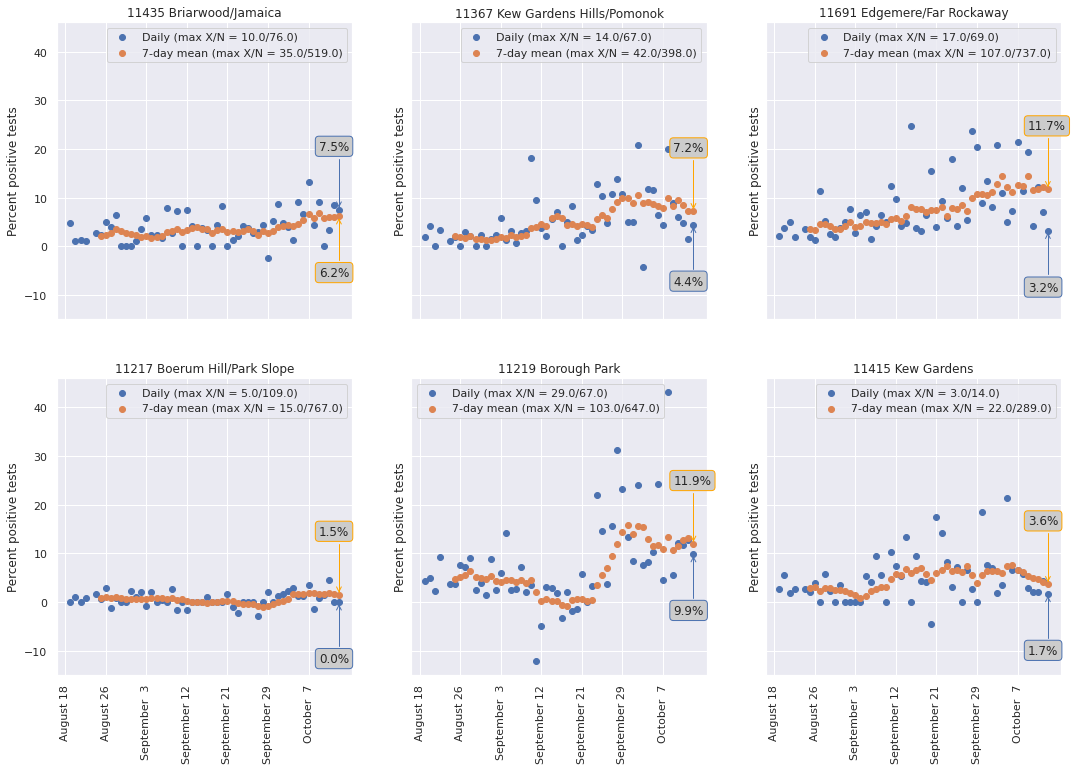

In [17]:

fig, axs = plt.subplots(height, width, figsize=(6 * width, 6 * height), sharex=True, sharey=True)
if not isinstance(axs, Iterable):
    axs = np.array([axs])
if len(axs.shape) < 2:
    axs = np.expand_dims(axs, axis=1)
bbbox = dict(boxstyle="round", fc="0.8", color='b')
barrowprops = dict(
    arrowstyle="->", color='b',
    connectionstyle="angle,angleA=0,angleB=90,rad=10")
obbox = dict(boxstyle="round", fc="0.8", color='orange')
oarrowprops = dict(
    arrowstyle="->", color='orange',
    connectionstyle="angle,angleA=0,angleB=90,rad=10")        
for zipc, ax in zip(zip_codes, axs.ravel()):
    ccc = ndf[['COVID_CASE_COUNT', 'TOTAL_COVID_TESTS']].loc[zipc].unstack(level=0).reindex(keep_times[::-1])
    diffdf = ccc
    dcc = rdf[['COVID_CASE_COUNT', 'TOTAL_COVID_TESTS']].loc[zipc].unstack(level=0).reindex(keep_times[::-1])
    # rdf = diffdf.rolling(7).sum()
    xvals = np.arange(len(diffdf))
    yvals = diffdf['COVID_CASE_COUNT']/diffdf['TOTAL_COVID_TESTS'] * 100
    ryvals = dcc['COVID_CASE_COUNT']/dcc['TOTAL_COVID_TESTS'] * 100
    ymax = np.argmax(yvals.replace([np.inf, -np.inf], np.nan))
    rymax = np.argmax(ryvals.replace([np.inf, -np.inf], np.nan))
    ax.scatter(xvals, yvals, label='Daily (max X/N = {}/{})'.format(*diffdf.iloc[ymax].values))
    ax.scatter(xvals, ryvals, label='7-day mean (max X/N = {}/{})'.format(*dcc.iloc[rymax].values))
    ax.set_title('{} {}'.format(zipc, nhds[zipc]))
    yshift = 60
    factor = 1
    if yvals.iloc[-1] < ryvals.iloc[-1]:
        factor *= -1
    ax.annotate('{:.01f}%'.format(yvals.iloc[-1]), (xvals[-1], yvals.iloc[-1]), xytext=(-20, factor * 60), textcoords='offset points',
    bbox=bbbox, arrowprops=barrowprops)
    ax.annotate('{:.01f}%'.format(ryvals.iloc[-1]), (xvals[-1], ryvals.iloc[-1]), xytext=(-20, factor * -60), textcoords='offset points',
    bbox=obbox, arrowprops=oarrowprops)
for ax in axs.ravel():
    ax.set_xticks(list(range(len(keep_times))[::8]))
    ax.set_xticklabels(keep_dates[::-1][::8], rotation=90)
    ax.set_ylabel('Percent positive tests')
    ax.legend()
fig.savefig('nyc_caserate.png')
fig.savefig('nyc_caserate.pdf')
plt.close('all')
fig

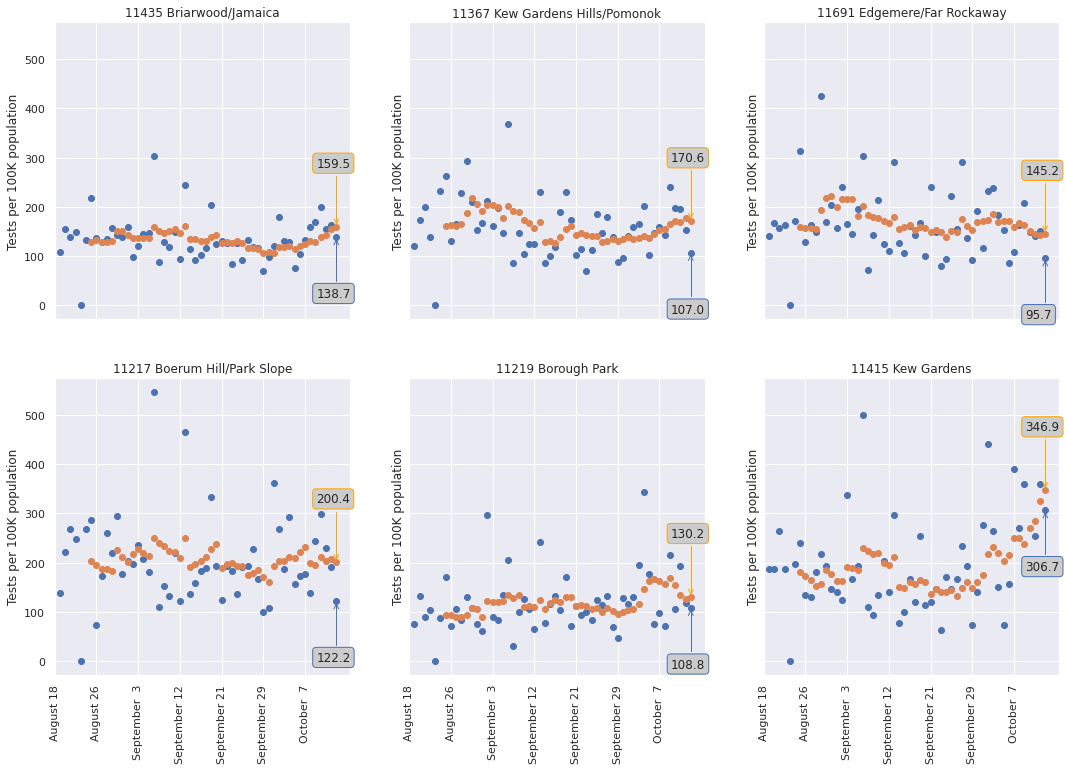

In [18]:
fig, axs = plt.subplots(height, width, figsize=(6 * width, 6 * height), sharex=True, sharey=True)
if not isinstance(axs, Iterable):
    axs = np.array([axs])
if len(axs.shape) < 2:
    axs = np.expand_dims(axs, axis=1)
for zipc, ax in zip(zip_codes, axs.ravel()):
    ccc = cdf[['TOTAL_COVID_TESTS', 'POP_DENOMINATOR']].loc[zipc].unstack(level=0)
    diffdf = ccc.diff()
    drdf = diffdf.rolling(7).mean()
    xvals = np.arange(len(diffdf))
    yvals = diffdf['TOTAL_COVID_TESTS']/ccc['POP_DENOMINATOR'] * 100000
    ryvals = drdf['TOTAL_COVID_TESTS']/ccc['POP_DENOMINATOR'] * 100000
    ax.scatter(xvals, yvals)
    ax.scatter(xvals, ryvals)
    ax.set_title('{} {}'.format(zipc, nhds[zipc]))
    ax.set_xlim(xmin=0)
    yshift = 60
    factor = 1
    if yvals.iloc[-1] < ryvals.iloc[-1]:
        factor *= -1
    ax.annotate('{:.01f}'.format(yvals.iloc[-1]), (xvals[-1], yvals.iloc[-1]), xytext=(-20, factor * 60), textcoords='offset points',
    bbox=bbbox, arrowprops=barrowprops)
    ax.annotate('{:.01f}'.format(ryvals.iloc[-1]), (xvals[-1], ryvals.iloc[-1]), xytext=(-20, factor * -60), textcoords='offset points',
    bbox=obbox, arrowprops=oarrowprops)
for ax in axs.ravel():
    ax.set_xticks(list(range(len(keep_times))[::8]))
    ax.set_xticklabels(keep_dates[::-1][::8], rotation=90)
    ax.set_ylabel('Tests per 100K population')
fig.savefig('nyc_testing.png')
fig.savefig('nyc_testing.pdf')
plt.close('all')
fig

In [19]:
# load the data
nyc_boroughs = gpd.read_file(gplt.datasets.get_path('nyc_boroughs'))

In [20]:
zipshape = gpd.read_file("/home/yakov/code/nyccovid/zip_code_040114.geojson").set_index('ZIPCODE')

In [21]:
zipdata = zipshape.copy()
colnames = ['perc_pos', 'roll_perc_pos']
for ixdf, sername in zip([cdf, rdf], colnames):
    subdf = ixdf.swaplevel(axis=1)[keep_times[0]][['COVID_CASE_COUNT', 'TOTAL_COVID_TESTS']]
    ser = subdf['COVID_CASE_COUNT'] / subdf['TOTAL_COVID_TESTS'] * 100
    ser.index.name = 'ZIPCODE'
    ser.index = ser.index.map(str)
    zipdata[sername] = ser

In [22]:
proj = gcrs.AlbersEqualArea(central_latitude=40.7128, central_longitude=-74.0059)
fig, axs = plt.subplots(1, 2, figsize=(12, 24), subplot_kw={'projection': proj}, dpi=1200)
for ax, col, color in zip(axs.ravel(), colnames, ['Blues', 'Reds']):
    gplt.polyplot(nyc_boroughs, ax=ax)
    gplt.choropleth(zipdata.loc[:, [col, 'geometry']], hue=col, cmap=color, ax=ax, linewidth=0.1)
fig.tight_layout()
fig.savefig("nyc_map.png", bbox_inches='tight')
fig.savefig("nyc_map.pdf", bbox_inches='tight')
plt.close('all')